# Main Notebook: NLP Series Workshop 3: Recurrent Seq2Seq for Language Translation

<span style="color:red">__DISCLAIMER__</span> : This dataset may contain explicit content. 

Conventions used:

❗ - Required <br />
❓ - Question

Credit to these wonderful resources which we used as a basis for this workshop: 

* https://keras.io/examples/nlp/lstm_seq2seq/
* https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
* https://www.analyticsvidhya.com/blog/2020/08/a-simple-introduction-to-sequence-to-sequence-models/#:~:text=Sequence%20to%20Sequence%20

## 1. Setup and Exploration

### a. Setup

The dataset we'll use can be found here: http://www.manythings.org/anki/fra-eng.zip

Download Dataset

In [ ]:
!curl -O http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6457k  100 6457k    0     0  39.1M      0 --:--:-- --:--:-- --:--:-- 39.1M
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

Configuration

In [ ]:
latent_dim = 256  # Latent dimensionality of the encoding space.

# Path to the data txt file on disk.
data_path = "fra.txt"
data = pd.read_csv(data_path, header=None, sep="\t", names=["English","French", "Citation"], encoding="utf-8")

num_samples = 10000  # Number of samples to train on.

### b. Exploration

This data set is split into short English sentences and their French translations. Let's take a look!

In [ ]:
data

,English,French,Citation
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
194508,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
194509,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
194510,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
194511,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


We're going to take a subset of the data of size `num_samples` defined in our Configuration from earlier. This is because Google Colab has limitations on RAM.

In [ ]:
data = data.head(num_samples)

In [ ]:
data

,English,French,Citation
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
9995,Happy holidays.,Bonnes vacances !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9996,Has it arrived?,Est-ce que c'est arrivé ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
9997,Have they gone?,Sont-ils partis ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9998,Have they gone?,Sont-elles parties ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


## 2. Preprocessing

First, let's split up the data.

Our input text is English and our output text are the corresponding French translations. We'll save all this data to lists `input_texts` and `target_texts`.

From these arrays, we'll create 2 sets.
- `input_characters` will be all the unique characters in the input text 
- `target_characters` will be all the unique characters in the target text
  - **Note**: we add `\t` and `\n` to each element since it will be useful for inference at the end

A set is like an array, but there are *no duplicate elements*. These sets will be useful in our next steps of preprocessing!

In [ ]:
# get all sentences from input (English) and target (French)
input_texts = data['English'].to_numpy()
target_texts = [ '\t' + text + '\n' for text in data['French'].to_numpy() ]

# get all unique characters in input and target using set()
input_characters = set(''.join(input_texts))
target_characters = set(''.join(target_texts))

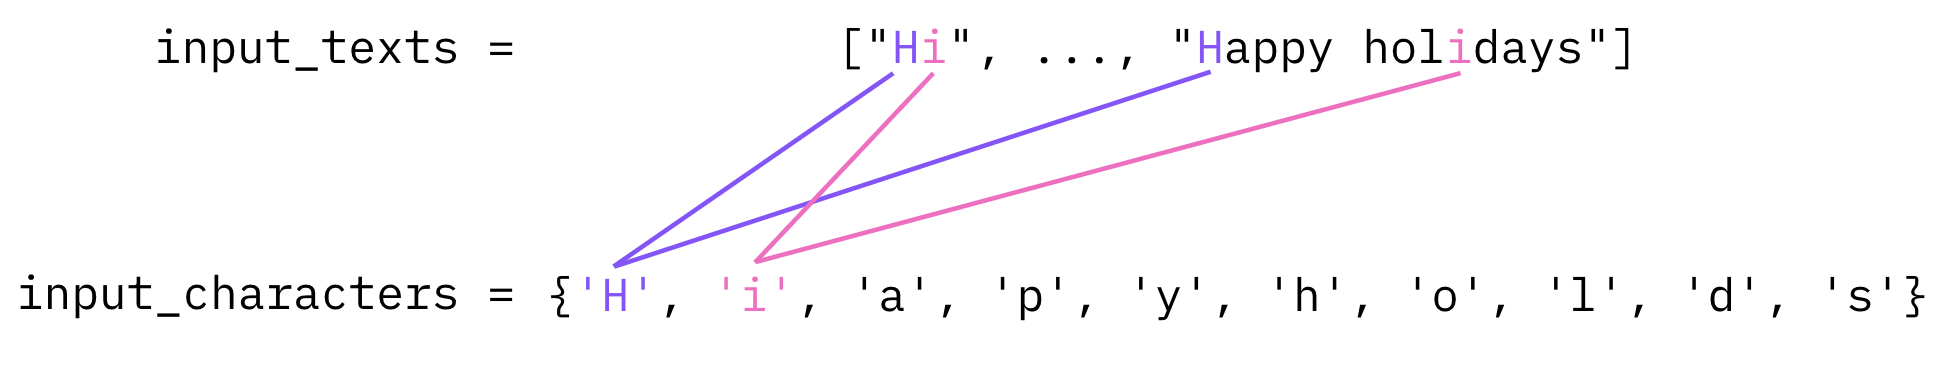

### a. Encoding and Decoding

We have three important terms to know for this next section.

**Encoder:** The encoder processes each token in the input-sequence. It tries to cram all the information about the input-sequence into a vector of fixed length i.e. the ‘context vector’. After going through all the tokens, the encoder passes this vector onto the decoder.

**Context Vector:** A vector of numbers that encodes information in the input sequence (the English text). The Decoder's job is to turn this information into a French sentence.

**Decoder:** The decoder reads the context vector and tries to predict the target-sequence token by token.

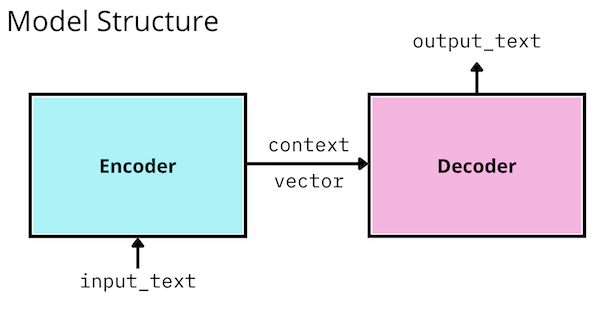

It's time to create some variables related to our tokens.

In our Seq2Seq model, the individual characters of the English and French words are referred to as tokens.

In [ ]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

Let's check out some stats about our data!

In [ ]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


### b. Preparing for Encoding and Decoding

We will be mapping from a given character to the index that represents said character in the encoder/decoder data

In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

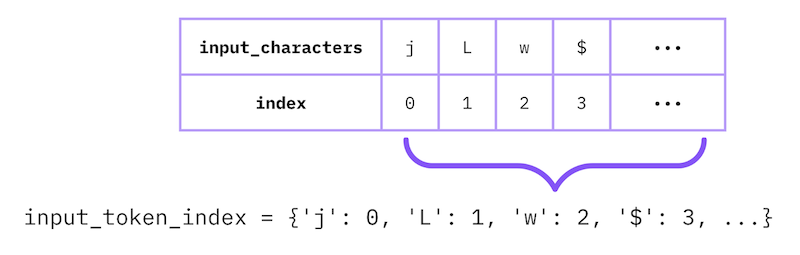

Now, we will create three arrays filled with zeros. These will be arrays based on the length of the input texts, the length of the longest sequence, and number of tokens.



In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [ ]:
print("encoder_input_data shape", encoder_input_data.shape)
print("decoder_input_data shape", decoder_input_data.shape)
print("decoder_target_data shape", decoder_target_data.shape)

encoder_input_data shape (10000, 15, 71)
decoder_input_data shape (10000, 59, 93)
decoder_target_data shape (10000, 59, 93)


### c. Building Encoder and Decoder

After the encoder reads the whole input-sequence, it passes the internal states (the context vector) to the decoder and this is where the prediction of output-sequence begins.

**Note**: This function is fairly complicated and low-level. Try spending some time finding out what each function does, and how each statement builds the 3-D arrays for `encoder_input_data`, `decoder_input_data`, and `decoder_target_data`.

For example, the output of the code `enumerate(zip(input_text, target_text))` is diagramed below:

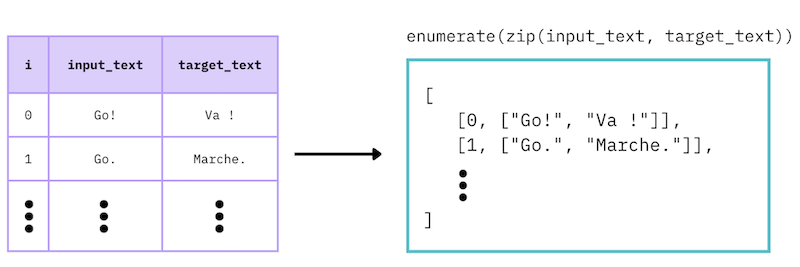

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

We have now vectorized our data and are ready to move on to the next step, building our model!

## 3. Building the Model

### a. What is a Seq2Seq model?

A Seq2Seq model is a type of Recurrent Neural Network (RNN) that we can use for language translation.

It commonly uses the Encoder-Decoder architecture, which we are using in this notebook.

### b. What is the Encoder-Decoder architecture (at a high level)?

The Encoder reads the input sequence and summarizes the information in something called the internal state vectors or context vector. We discard the outputs of the encoder and only preserve the internal states.

Using the final states of the encoder as its initial states, the decoder starts generating the output sequence, and these outputs are also taken into consideration for future outputs.

### c. Defining Input Sequence and Processing

We will be using LSTM layers, which provide a sequence of outputs rather than a single value output.

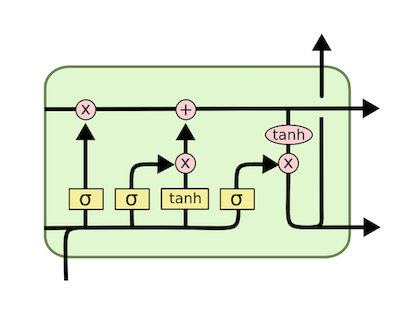

Source for above image: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

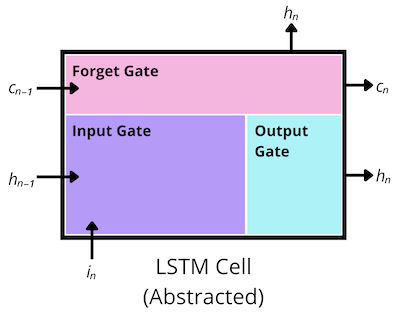

LSTMs make a few key decisions which help them process text very effectively:

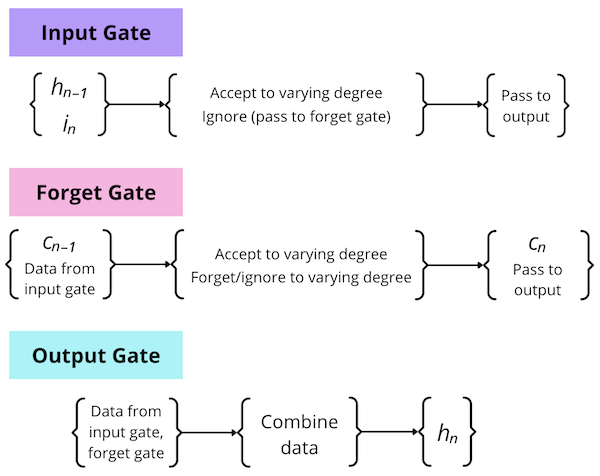

In [ ]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

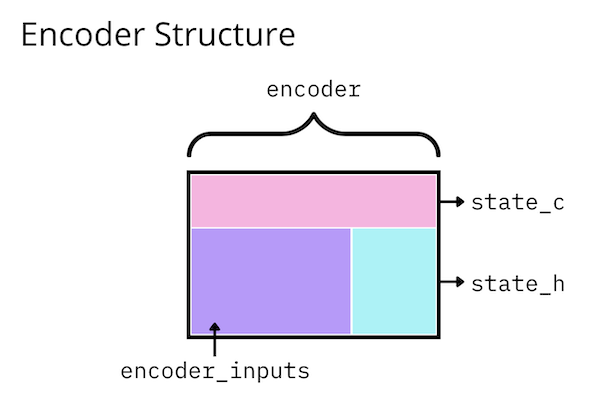

We need to put these encoder inputs in the context vector and set up the decoder

In [ ]:
# We discard `encoder_outputs` and only keep the states.
# Explanation for this in training.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

Let's finish setting up the decoder:

In [ ]:
# Set up the decoder to return full output sentences
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# We return to our internal states
# We add an LSTM layer for encoding and decoding
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
# Our decoder output layer
decoder_outputs = decoder_dense(decoder_outputs)

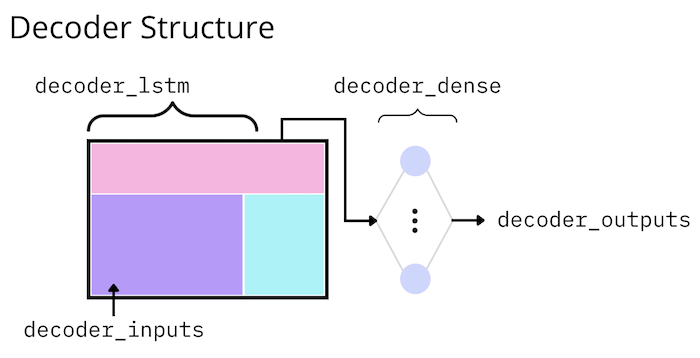

Finally, we can build our model!

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

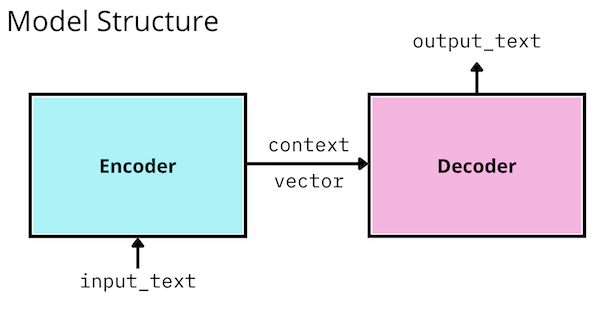

## 4. Training the Model

We'll use `fit()` to train our model.

- **encoder_input_data**: English training sentences
- **decoder_input_data**: encoded English sentences
- **decoder_target_data**: French sentences
- **epochs**: number of times the model will go through the dataset
- **batch_size**: number of training samples that go through the model

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100      # Number of epochs to train for.

❓ *How Does a Decoder Train?*

It uses something called *Teacher Forcing*. Teacher forcing is a strategy for training recurrent neural networks that uses ground truth as input, instead of model output from a prior time step as an input.

❓ *What is ground truth?*
Ground truth is real world data, so basically test data without labels.

We use the current target word as the decoder’s next input rather than using the decoder’s current guess. This allows us to ensure that the model does not get off track when training, as we can use correct target word as input to guess the next word if the model guesses incorrectly.

Here's a helpful resource to better understand teacher forcing: https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

In [1]:
# Compile the model
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Fit the model on the data & finetune it with validation data
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

NameError: ignored

## 5. Inference

Let's load in our model and break it up into its encoder and decoder components.

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
print(reverse_input_char_index)

{0: '1', 1: 'B', 2: '"', 3: 'i', 4: 'u', 5: 'q', 6: '9', 7: 'C', 8: 'R', 9: 'E', 10: 'm', 11: 'o', 12: 'A', 13: 'D', 14: '?', 15: 't', 16: 'r', 17: 'Y', 18: '%', 19: 'K', 20: 'S', 21: '3', 22: '&', 23: 'g', 24: 'd', 25: '2', 26: 'U', 27: 'x', 28: 'j', 29: 'W', 30: ' ', 31: '$', 32: 'M', 33: 'V', 34: '!', 35: 'h', 36: 'v', 37: 'k', 38: 'G', 39: "'", 40: 'F', 41: '0', 42: 'f', 43: 'n', 44: 'P', 45: 'e', 46: 'z', 47: 'c', 48: 'O', 49: '7', 50: '.', 51: ',', 52: 'a', 53: 'l', 54: 'T', 55: '8', 56: 'N', 57: 'H', 58: 's', 59: 'L', 60: 'I', 61: 'J', 62: ':', 63: 'y', 64: 'p', 65: 'Q', 66: 'é', 67: '-', 68: 'b', 69: 'w', 70: '5'}


In [ ]:
print(reverse_target_char_index)

{0: 'î', 1: 'm', 2: 'Y', 3: 'r', 4: 'â', 5: '3', 6: '2', 7: '\t', 8: 'U', 9: '»', 10: ' ', 11: 'G', 12: 'n', 13: 'z', 14: 'l', 15: 'Ç', 16: 'ï', 17: 's', 18: 'I', 19: '5', 20: '«', 21: '1', 22: '’', 23: 'i', 24: '9', 25: 'C', 26: 'R', 27: 'E', 28: 'A', 29: 'S', 30: '&', 31: 'g', 32: '\u202f', 33: 'd', 34: 'M', 35: '\u2009', 36: 'V', 37: 'À', 38: '!', 39: 'v', 40: '(', 41: 'û', 42: 'e', 43: 'c', 44: 'O', 45: 'H', 46: 'ù', 47: 'Q', 48: 'y', 49: 'è', 50: ')', 51: 'b', 52: '%', 53: 'q', 54: 'o', 55: 'Ê', 56: 'j', 57: 'W', 58: 'h', 59: "'", 60: 'F', 61: 'P', 62: 'ç', 63: '\xa0', 64: '.', 65: ',', 66: 'a', 67: 'T', 68: '8', 69: 'N', 70: 'à', 71: 'L', 72: '-', 73: 't', 74: '\n', 75: 'B', 76: 'u', 77: 'D', 78: '?', 79: 'K', 80: 'x', 81: 'É', 82: 'œ', 83: 'k', 84: '0', 85: 'f', 86: 'ê', 87: 'ô', 88: ':', 89: 'J', 90: 'p', 91: 'é', 92: 'w'}


Below is the function for taking in an input sequence (an English sentence), and it will output a French sentence! We won't dive into the exact details of this convoluted function, but we will provide a small recap!

1. It preprocesses the English sentence into numbers (exactly like how we did it in training).
2. It will feed this quantified sentence into the encoder. 
3. The encoder's context vector will be fed into the decoder model.
4. The decoder model will generate a sequence of numbers corresponding to the French look-up table.
5. This sentence is mapped from numbers into the French characters.

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

Here's the actual inference part.

In [ ]:
import random

random_indices = [random.randint(0, num_samples) for x in range(10)]

for seq_index in random_indices:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence, end="")
    print("Actual decode:", target_texts[seq_index][1:len(target_texts[seq_index])])

Input sentence: I was pleased.
Decoded sentence: J'ai été contente.
Actual decode: J'ai été content.

Input sentence: Tom is huge.
Decoded sentence: Tom est énorme.
Actual decode: Tom est énorme.

Input sentence: I made a deal.
Decoded sentence: J'ai conclu un contrat.
Actual decode: J'ai conclu un accord.

Input sentence: They found us.
Decoded sentence: Ils ont transpiré.
Actual decode: Elles nous ont trouvées.

Input sentence: Who hates you?
Decoded sentence: Qui l'a perule ?
Actual decode: Qui te déteste ?

Input sentence: Fill it up.
Decoded sentence: Le plein.
Actual decode: Le plein.

Input sentence: See you!
Decoded sentence: À la prochaine !
Actual decode: À bientôt !

Input sentence: Get away!
Decoded sentence: Dégage !
Actual decode: Bouge !

Input sentence: Do you love me?
Decoded sentence: Tu contez plus ?
Actual decode: Tu m'aimes ?

Input sentence: Contact my son.
Decoded sentence: Ne fouc pas di pous.
Actual decode: Prenez contact avec mon fils !



## 6. Conclusion

To recap, here's what we did:

1. Downloaded and imported our libraries.
2. Took a look at the data (in table format).
3. Preprocessed our data into a 3-dimensional array of shape (batch_size, max_sequence_length, num_tokens) for the encoder input data, the decoder input data, and the decoder target data.
4. Built our simple seq2seq model and trained it.
5. Ran inference!

This notebook provided a small peek into the world of language translation with NLP (and deep learning)! We hope this notebook and our explanations sparked a little curiosity in you to explore other NLP avenues. Much thanks to the credited people listed at the top of this notebook. With that, this concludes our 3-part NLP workshop series for spring quarter 2022. We thank you for giving this code a look! 🙂